# Question 1
Does geographical location affect the quality rating for a hospital or mortality rate for a specific procedure?

## Initial Observations
From the data frame below, we can see that the "As Expected" category for hospital ratings is the overwhelming majority category. We can also see that the dataset captures a larger variety of counties with more proportional representation from each category than for the hospital ratings.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix

df = pd.read_csv("CMSC320_FinalProj_Database.csv")
print(df['Hospital Ratings'].value_counts().head())
print(df['COUNTY'].value_counts().head(10))
df

As Expected    33093
Better          1581
Worse           1504
None             180
Name: Hospital Ratings, dtype: int64
Los Angeles       13968
Orange             4044
San Bernardino     3060
Riverside          2964
San Diego          2714
Alameda            2104
San Francisco      1828
Kern               1800
Santa Clara        1620
Sacramento         1440
Name: COUNTY, dtype: int64


,YEAR,COUNTY,HOSPITAL,OSHPDID,Procedure/Condition,Risk Adjusted Mortality Rate,# of Deaths,# of Cases,Hospital Ratings,LONGITUDE,LATITUDE
0,2016,AAAA,STATEWIDE,None,AAA Repair Unruptured,1.3,30,2358,None,None,None
1,2016,AAAA,STATEWIDE,None,AMI,6.1,3178,52167,None,None,None
2,2016,AAAA,STATEWIDE,None,Acute Stroke,9.1,5482,60184,None,None,None
3,2016,AAAA,STATEWIDE,None,Acute Stroke Hemorrhagic,21.1,2580,12210,None,None,None
4,2016,AAAA,STATEWIDE,None,Acute Stroke Ischemic,5,2258,45141,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
57649,2022,Yuba,Adventist Health and Rideout,106580996,Heart Failure,3.6,23,712,As Expected,-121.593602,39.138805
57650,2022,Yuba,Adventist Health and Rideout,106580996,Hip Fracture,4,6,167,As Expected,-121.593602,39.138805
57651,2022,Yuba,Adventist Health and Rideout,106580996,PCI,4.3,7,146,As Expected,-121.593602,39.138805
57652,2022,Yuba,Adventist Health and Rideout,106580996,Pancreatic Resection,NaN,NaN,NaN,NaN,-121.593602,39.138805


## Clean the Dataset
We have to remove all non-numeric/null quantities from each of the tables. We also have to remove the "None" category from the hospital ratings since "None" will not provide us with any valuable information for our classification/regression.

In [86]:
# Load and basic clean
df.replace("None", pd.NA, inplace=True)
df.columns = df.columns.str.strip()
df.dropna(inplace=True)

# Ensure numeric types for necessary columns
df["# of Deaths"] = pd.to_numeric(df["# of Deaths"], errors="coerce")
df["# of Cases"] = pd.to_numeric(df["# of Cases"], errors="coerce")
df.replace(".", "None", inplace=True)

df["Risk Adjusted Mortality Rate"] = pd.to_numeric(df["Risk Adjusted Mortality Rate"], errors="coerce")

# Drop rows where conversion failed (NaNs)
df.dropna(subset=["# of Deaths", "# of Cases", "Risk Adjusted Mortality Rate", "Hospital Ratings"], inplace=True)
df

,YEAR,COUNTY,HOSPITAL,OSHPDID,Procedure/Condition,Risk Adjusted Mortality Rate,# of Deaths,# of Cases,Hospital Ratings,LONGITUDE,LATITUDE
17,2016,Alameda,Alameda Hospital,106010735,AMI,16.1,3,17,As Expected,-122.253991,37.76266
18,2016,Alameda,Alameda Hospital,106010735,Acute Stroke,23.6,9,74,Worse,-122.253991,37.76266
19,2016,Alameda,Alameda Hospital,106010735,Acute Stroke Hemorrhagic,48.9,5,9,Worse,-122.253991,37.76266
20,2016,Alameda,Alameda Hospital,106010735,Acute Stroke Ischemic,15.2,4,65,As Expected,-122.253991,37.76266
24,2016,Alameda,Alameda Hospital,106010735,GI Hemorrhage,4.6,5,83,As Expected,-122.253991,37.76266
...,...,...,...,...,...,...,...,...,...,...,...
57648,2022,Yuba,Adventist Health and Rideout,106580996,GI Hemorrhage,2.5,6,247,As Expected,-121.593602,39.138805
57649,2022,Yuba,Adventist Health and Rideout,106580996,Heart Failure,3.6,23,712,As Expected,-121.593602,39.138805
57650,2022,Yuba,Adventist Health and Rideout,106580996,Hip Fracture,4.0,6,167,As Expected,-121.593602,39.138805
57651,2022,Yuba,Adventist Health and Rideout,106580996,PCI,4.3,7,146,As Expected,-121.593602,39.138805


## Data visualization
The following scatterplot plots the geographic locations of each of the hospitals. The legend on the right side of the graph shows the rating of the hospitals. Just from looking at the graph alone, we can't tell a lot about if location has an impact on the hospital ratings since the hospitals with "Worse" or "Better" ratings are distributed somewhat evenly.

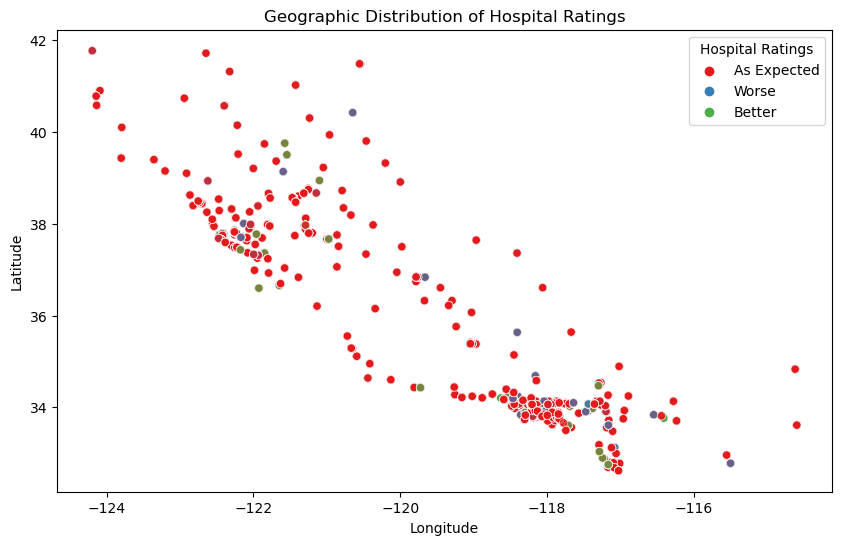

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="LONGITUDE",
    y="LATITUDE",
    hue="Hospital Ratings",
    palette="Set1",
    alpha=0.7
)
plt.title("Geographic Distribution of Hospital Ratings")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Set the Features and Targets
We are trying to predict hospital ratings given the location of the hospital. For the location, we need to know the latitude, longitude, and county to know the location of the hospitals. We also need to remove any non-numeric quantities from the latitude and longitude features to feed the data into the machine learning model.

In [88]:
features = ["LATITUDE", "LONGITUDE", "COUNTY"]
target = "Hospital Ratings"

df["LATITUDE"] = pd.to_numeric(df["LATITUDE"], errors="coerce")
df["LONGITUDE"] = pd.to_numeric(df["LONGITUDE"], errors="coerce")

df.dropna(subset=["LATITUDE", "LONGITUDE"], inplace=True)

X = df[features]
y = df[target]

## Feed the Data Into an ML Model
After preparing our data, we can put our data into a machine learning model to predict the hospital rating given its location (latitude, longitude, county). Notice that we need to convert "County" into a numeric variable since "County" is currently a categorical variable.

Classification Report:
              precision    recall  f1-score   support

 As Expected       0.95      0.48      0.63      8227
      Better       0.12      0.62      0.20       395
       Worse       0.09      0.68      0.16       376

    accuracy                           0.49      8998
   macro avg       0.39      0.59      0.33      8998
weighted avg       0.88      0.49      0.60      8998

Confusion Matrix:


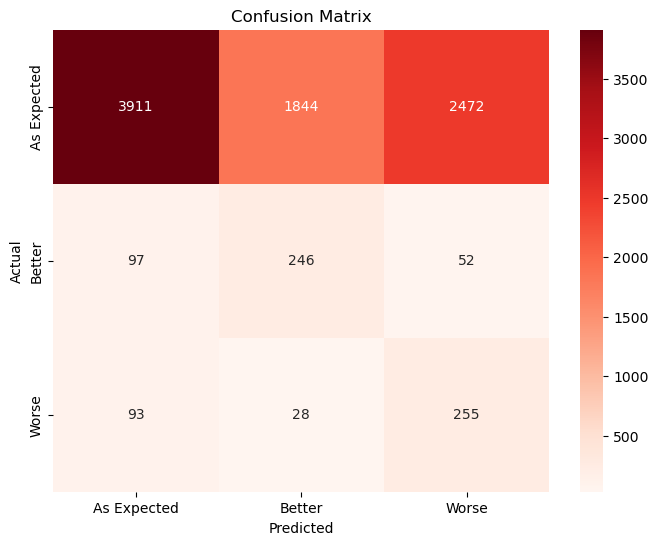

In [90]:
# Note: COUNTY is not numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["LATITUDE", "LONGITUDE"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["COUNTY"])
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",  RandomForestClassifier(n_estimators=100, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classification Analysis
For predicting hospital ratings, I used the random forest classification method. Since hospital ratings is a categorical variable, it makes sense to use a classification model instead of a regression model. However, since the "As Expected" category was the overwhelming majority of the data, my model couldn't predict hospitals in the "Better" or "Worse" ratings as accurately as it predicted the "As Expected" category. Another reason for the low accuracy is that from our scatterplot (refer to <b>Data Visualization</b>) we see that there is little to no correlation between the location and the hospital quality ratings. It's possible that this lack of correlation made it difficult for the model to find patterns and accurately predict the hospital ratings.

R² Score: 0.82


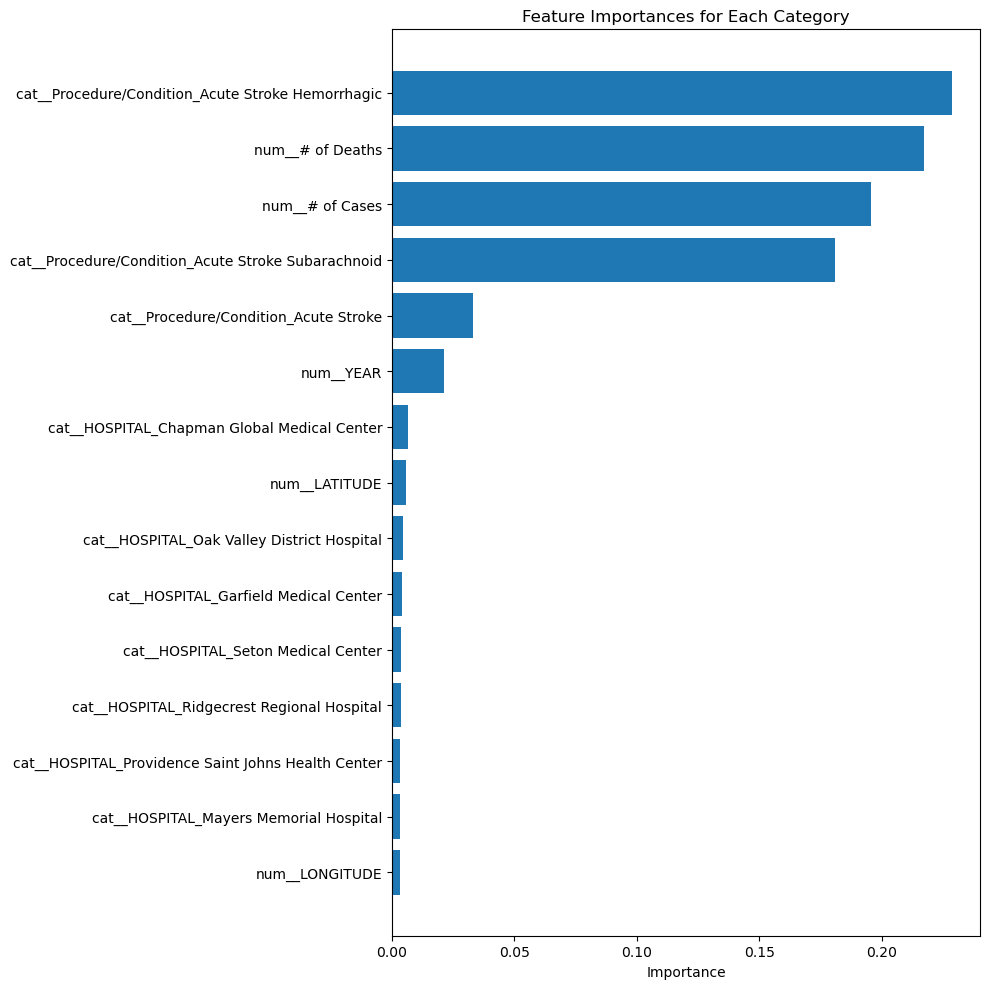

In [92]:
# Remove NA
df.columns = df.columns.str.strip()
df = df.dropna(subset=["YEAR", "# of Deaths", "# of Cases", "Procedure/Condition",
    "HOSPITAL", "COUNTY", "LATITUDE", "LONGITUDE", "Risk Adjusted Mortality Rate"])

# Features and targets
features = ["YEAR", "# of Deaths", "# of Cases", "Procedure/Condition",
            "HOSPITAL", "COUNTY", "LATITUDE", "LONGITUDE"]
target = "Risk Adjusted Mortality Rate"

X = df[features]
y = df[target]

num_features = ["YEAR", "# of Deaths", "# of Cases", "LATITUDE", "LONGITUDE"]
cat_features = ["Procedure/Condition", "HOSPITAL", "COUNTY"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(n_estimators=175, max_depth=6))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Print result of regression
print(f"R² Score: {r2:.2f}")

preprocessed_X = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

gbr = GradientBoostingRegressor(n_estimators=175, max_depth=6)
gbr.fit(preprocessed_X, y)
importances = gbr.feature_importances_

indices = np.argsort(importances)[-15:]
plt.figure(figsize=(10, 10))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.title("Feature Importances for Each Category")
plt.tight_layout()
plt.show()

## Regression Analysis
After using gradient boosting regression, we can see that the latitude, longitude, and county have little to no importance in the prediction of risk adjusted mortality rate. However, the acute stroke hemorrhagic procedure, number of deaths, and number of cases has a very high importance when predicting risk adjusted mortality rate. It's also important to note that the model's accuracy ($R^2$ in the case for regression), is $0.87$, much higher than the accuracy rate for the random forest classifier.

## Conclusion
From our random forest classification, we can see that the physical location of the hospital <b>does not</b> have a noticeable impact on the quality rating of a hospital. This corresponds with our initial observation that the hospitals rated "Better", "Worse", and "As Expected" seem to be evenly distributed in the scatterplot. After getting a lower accuracy for predicting hospital ratings, we then used gradient boosting regression to determine what kinds of features impact the mortality rates for given procedures. From our regression analysis, we can see that non location-based features such as # of deaths and # of cases predict the mortality rates of procedures much more than location-based features. This result explains why our original classification was getting a somewhat low accuracy.